#### This notebook compares rescaling of zstack using static theories or a dynamic scaling factor theory.
###### We use microscopy data of beads stuck in agarose to compare theories.
###### The comparison is made between stacks recorded with a water objective (ground truth) and an oil objective.

###### First, we import packages and functions:

In [1]:
import psf_extra as psfe
import numpy as np
import matplotlib.pyplot as plt

from utils import *

###### Next, we import the data:

In [2]:
#load stacks
location = r"M:\tnw\ist\do\projects\Cryo\Experiments\Axial_scaling_bead_data\data_for_Daan\NA1.4" #location of stacks
gt_stack = psfe.load_stack(location+'\gt_stack_NA1.4_oil.tif')
distorted_stack = psfe.load_stack(location+'\distorted_stack_NA1.4_oil.tif')

shape_gt = np.shape(gt_stack)
shape_distorted = np.shape(distorted_stack)

# The cover slip should be at the last z-slice 
# To check: (this should an image of the beads on the cover slip)
#plt.imshow(gt_stack[-1])
#plt.show()

#Then, if necessary: invert z direction
#gt_stack = gt_stack[::-1, :, :]
#distorted_stack = distorted_stack[::-1, :, :]

if len(shape_gt) > 3:
    gt_stack = gt_stack[:,:,:,0]
    shape_gt = np.shape(gt_stack)
if len(shape_distorted) > 3:
    distorted_stack = distorted_stack[:,:,:,0]
    shape_distorted = np.shape(distorted_stack)

print('Done!')

Done!


###### Next, we set the parameters of the data:

In [3]:
medium_gt = 'water'
ps_xy_gt = 0.1553701 # um
ps_z_gt = 0.5 # um

medium_distorted = 'oil'
ps_xy_distorted = 0.1242961 # um
ps_z_distorted = 0.5 # um

n_im = 1.518
n_sample = 1.3358 # 2w% agarose in water - https://www.nature.com/articles/s41598-020-64103-3
lam_0 = 0.52 # microns
NA = 1.4

###### As the axial distorted z-stack with a refractive index mismatch suffers from intensity loss as a function of depth, we rescale the intensity as a function of the depth:

In [4]:
distorted_stack_comp,_,_ = compensate_int_loss(distorted_stack,kernel_size=25,fit=False,skip_slides=20, plot=False)

#normalize to match histogram of gt stack:
factor = .3 # used to optimize histogram matching (see next cell)
distorted_stack_comp=distorted_stack_comp/(np.max(distorted_stack_comp)*factor)

#saturated values higher than 1 (for easier plotting):
distorted_stack_comp[distorted_stack_comp>1.0]=1.0

###### Optionally, check the intensity histograms of the ground truth stack and the distorted stack:
###### (This is a bit slow for large stacks...)

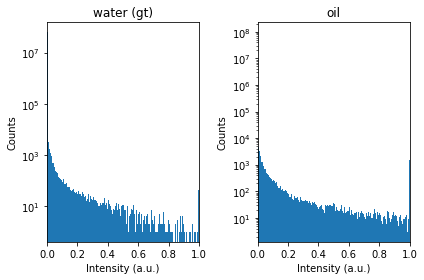

In [5]:
plot_int_histograms(gt_stack,distorted_stack_comp,[medium_gt+' (gt)',medium_distorted])

###### Next we plot the maximum intensity projections of the ground truth and distorted stacks to check the intensity loss compensation:

After intensity loss compensation:


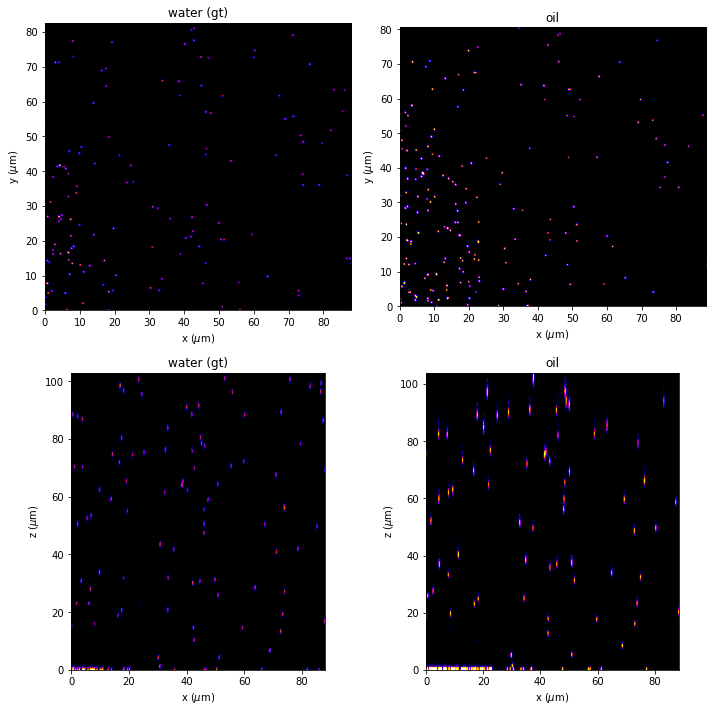

Before intensity loss compensation:


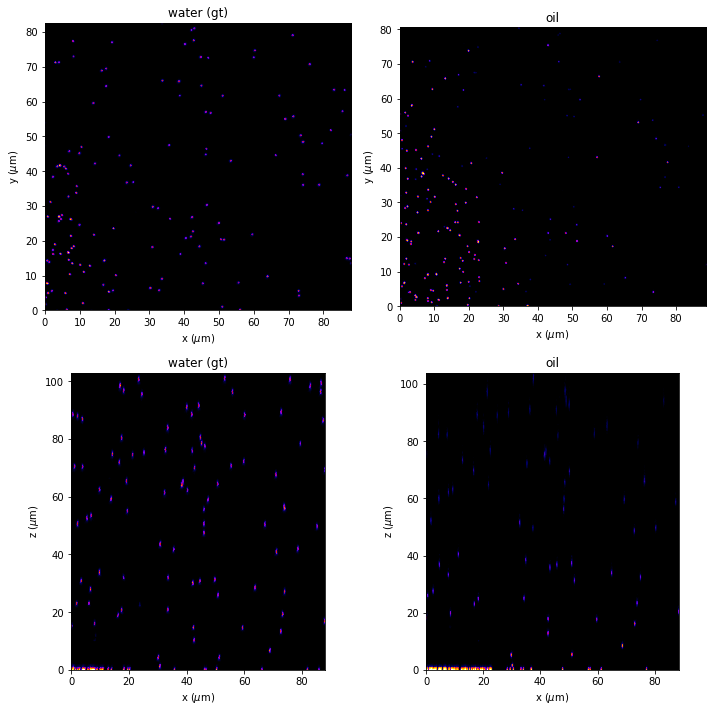

In [6]:
print("After intensity loss compensation:")
plot_stacks_MIPs(gt_stack,distorted_stack_comp,[medium_gt + ' (gt)',medium_distorted], ['xy','xz'], ps_xy_gt, ps_z_gt, ps_xy_distorted, ps_z_distorted)
print("Before intensity loss compensation:")
plot_stacks_MIPs(gt_stack,distorted_stack,[medium_gt + ' (gt)',medium_distorted], ['xy','xz'], ps_xy_gt, ps_z_gt, ps_xy_distorted, ps_z_distorted)

###### Perform the depth-dependent rescaling of the distorted stack:

In [5]:
stack_rescaled, afp_new_stack, afp_stack, nfp_stack = rescale_stack(distorted_stack_comp[::-1], NA, n_im, n_sample, lam_0, ps_z_gt,crit='Lyakin')

###### Plot the overlays of the rescaled data vs the ground truth data for the different theories:

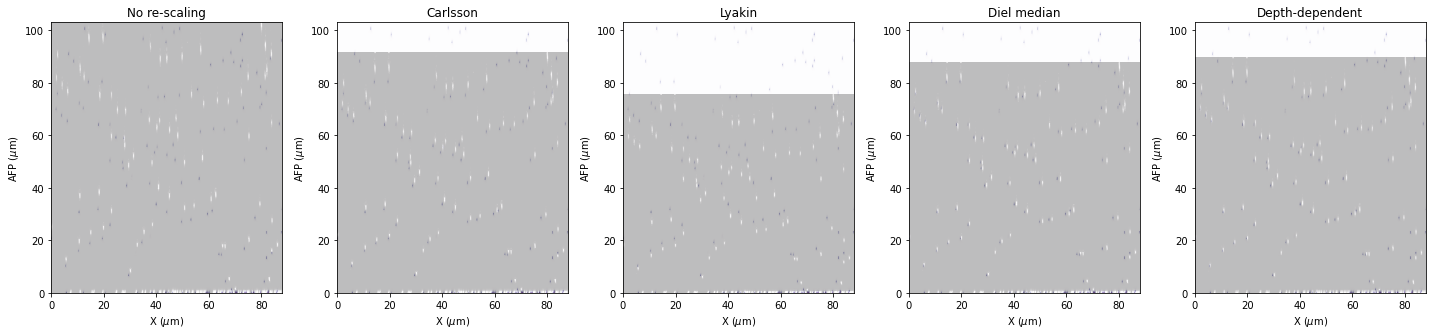

In [6]:
#define pixel sizes of linear re-scaled stacks
ps_z_distorted_diel_median = ps_z_distorted * diel_median([1],n_im,n_sample,NA)[0]
if n_sample > NA: ps_z_distorted_diel_mean = ps_z_distorted * diel_mean([1],n_im,n_sample,NA)[0]
else: ps_z_distorted_diel_mean = 0
ps_z_distorted_lyakin = ps_z_distorted * Lyakin([1],n_sample,n_im,NA)[0]

#define theories and corresponding pixel sizes for plotting:
theories = ['No re-scaling',
            'Carlsson',
            'Stallinga/Lyakin',
            'Diel median', 
            'Diel mean', 
            'Depth-dependent'
           ]
rescaled_ps_z = [ps_z_distorted, 
                 ps_z_distorted*n_sample/n_im,
                 ps_z_distorted_lyakin,
                 ps_z_distorted_diel_median,
                 ps_z_distorted_diel_mean,
                 ps_z_gt
                ]

if n_sample < NA: # Diel mean does not work when ref. index of sample is smaller than numerical aperture of objective
    theories.remove('Diel mean')
    rescaled_ps_z.remove(ps_z_distorted_diel_mean)
if n_im >= n_sample:
    theories = list(map(lambda x: x.replace('Stallinga/Lyakin', 'Lyakin'), theories))

#set ranges in plots (optional):
#y_min,y_max = 0, 50
#x_min,x_max = 110, 120

direction = 'horizontal' # stacking of panels in plot - "horizontal" or "vertical"

plot_overlay_panels(theories, 
                    distorted_stack_comp,stack_rescaled,gt_stack,
                    ps_xy_distorted,ps_z_distorted,
                    ps_xy_gt,ps_z_gt,
                    rescaled_ps_z,
                    #y_min,y_max,     # uncomment this line to set y limits in plot
                    #x_min,x_max,     # uncomment this line to set y limits in plot
                    direction = direction
                    )

In [7]:
%matplotlib inline


In [10]:
import matplotlib
# To save this stuff as SVG
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.use("svg")
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
matplotlib.rcParams.update(new_rc_params)

font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 8}
import matplotlib
matplotlib.rc('font', **font)

Saved to:  ./comparison_rescaling_dd_diels_oil_1.4NA.svg


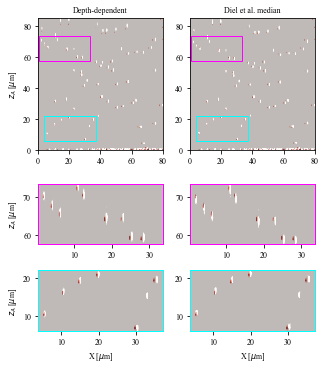

In [11]:
#### plot for figures
from matplotlib.patches import Rectangle
# make two column plot with d-d and diel median (diel mean cannot be computed as NA>n_sample)
# three rows: full range, top section, bottom section

#set ranges of top and bottom plots (in microns)
x_crop_top = [0.5,33.5]
top = [57.5,73.5]

x_crop_bot = [4,37]
#bottom = [0,18]
bottom = [6,22]


gt_vrange=[0.1,0.5]
dd_vrange = [0.1,0.3]
mean_vrange = [0.1,0.3]
med_vrange = [0.1,0.3]
colormaps = ['gray','Reds']
line_width=1

fig = plt.figure(dpi=150, figsize=[4.5, 5.2])
gs = fig.add_gridspec(8, 2)
ax_dd_full = fig.add_subplot(gs[:4,:1])
ax_dd_top = fig.add_subplot(gs[4:6,:1])
ax_dd_bot = fig.add_subplot(gs[6:8:,:1])
ax_med_full = fig.add_subplot(gs[:4,1:2])
ax_med_top = fig.add_subplot(gs[4:6,1:2])
ax_med_bot = fig.add_subplot(gs[6:8:,1:2])

#d-d
#plot full range
extent = [0, np.shape(stack_rescaled)[2]*ps_xy_distorted, 0, np.shape(stack_rescaled)[0]*ps_z_gt] # ps_z -> rescaled stack has been projected on pixel size of gt stack
ax_dd_full.imshow(np.max(np.flip(stack_rescaled,axis=0), axis=2),cmap=colormaps[0],extent=extent,alpha=0.5,vmin=dd_vrange[0],vmax=dd_vrange[1])
extent = [0, shape_gt[2]*ps_xy_gt, 0, shape_gt[0]*ps_z_gt]
ax_dd_full.imshow(np.max(gt_stack, axis=2),cmap=colormaps[1],extent=extent,alpha=0.5,vmin=gt_vrange[0],vmax=gt_vrange[1])    
ax_dd_full.set_aspect('equal')
ax_dd_full.set_xlim(0,80)
ax_dd_full.set_ylim(0,85)

ax_dd_full.add_patch(Rectangle((x_crop_top[0], top[0]), x_crop_top[1]-x_crop_top[0], top[1]-top[0],fill=False, edgecolor='magenta',lw=line_width))
ax_dd_full.add_patch(Rectangle((x_crop_bot[0], bottom[0]), x_crop_bot[1]-x_crop_bot[0], bottom[1]-bottom[0],fill=False, edgecolor='cyan',lw=line_width))

#plot top
extent = [0, np.shape(stack_rescaled)[2]*ps_xy_distorted, 0, np.shape(stack_rescaled)[0]*ps_z_gt] # ps_z -> rescaled stack has been projected on pixel size of gt stack
im1=ax_dd_top.imshow(np.max(np.flip(stack_rescaled,axis=0), axis=2),
                     cmap=colormaps[0],
                     extent=extent,
                     alpha=0.5,
                    vmin=dd_vrange[0],vmax=dd_vrange[1])
extent = [0, shape_gt[2]*ps_xy_gt, 0, shape_gt[0]*ps_z_gt]
ax_dd_top.imshow(np.max(gt_stack, axis=2),cmap=colormaps[1],extent=extent,alpha=0.5,vmin=gt_vrange[0],vmax=gt_vrange[1])    
ax_dd_top.set_aspect('equal')
ax_dd_top.set_xlim(x_crop_top)
ax_dd_top.set_ylim(top)

# Set the borders to a given color...
for spine in ax_dd_top.spines.values():
    spine.set_edgecolor('magenta')
    spine.set_linewidth(line_width)

#plot bottom
extent = [0, np.shape(stack_rescaled)[2]*ps_xy_distorted, 0, np.shape(stack_rescaled)[0]*ps_z_gt] # ps_z -> rescaled stack has been projected on pixel size of gt stack
ax_dd_bot.imshow(np.max(np.flip(stack_rescaled,axis=0), axis=2),cmap=colormaps[0],extent=extent,alpha=0.5,vmin=dd_vrange[0],vmax=dd_vrange[1])
extent = [0, shape_gt[2]*ps_xy_gt, 0, shape_gt[0]*ps_z_gt]
ax_dd_bot.imshow(np.max(gt_stack, axis=2),cmap=colormaps[1],extent=extent,alpha=0.5,vmin=gt_vrange[0],vmax=gt_vrange[1])    
ax_dd_bot.set_aspect('equal')
ax_dd_bot.set_xlim(x_crop_bot)
ax_dd_bot.set_ylim(bottom)
for spine in ax_dd_bot.spines.values():
    spine.set_edgecolor('cyan')
    spine.set_linewidth(line_width)


# ## diel mean
# #plot full range
# extent = [0, np.shape(distorted_stack)[2]*ps_xy_distorted, 0, np.shape(distorted_stack)[0]*rescaled_ps_z[4]]
# ax_mean_full.imshow(np.max(distorted_stack_comp, axis=2),cmap=colormaps[0],extent=extent,alpha=0.5,vmin=mean_vrange[0],vmax=mean_vrange[1]) 
# extent = [0, shape_gt[2]*ps_xy_gt, 0, shape_gt[0]*ps_z_gt]
# ax_mean_full.imshow(np.max(gt_stack, axis=2),cmap=colormaps[1],extent=extent,alpha=0.5,vmin=gt_vrange[0],vmax=gt_vrange[1])    
# ax_mean_full.set_aspect('equal')
# ax_mean_full.set_xlim(0,80)
# ax_mean_full.set_ylim(0,100)

# ax_mean_full.add_patch(Rectangle((x_crop_top[0], top[0]), x_crop_top[1]-x_crop_top[0], top[1]-top[0],fill=False, edgecolor='magenta',lw=line_width))
# ax_mean_full.add_patch(Rectangle((x_crop_bot[0], bottom[0]), x_crop_bot[1]-x_crop_bot[0], bottom[1]-bottom[0],fill=False, edgecolor='cyan',lw=line_width))


# #plot top
# extent = [0, np.shape(distorted_stack)[2]*ps_xy_distorted, 0, np.shape(distorted_stack)[0]*rescaled_ps_z[4]]
# ax_mean_top.imshow(np.max(distorted_stack_comp, axis=2),cmap=colormaps[0],extent=extent,alpha=0.5,vmin=mean_vrange[0],vmax=mean_vrange[1])
# extent = [0, shape_gt[2]*ps_xy_gt, 0, shape_gt[0]*ps_z_gt]
# ax_mean_top.imshow(np.max(gt_stack, axis=2),cmap=colormaps[1],extent=extent,alpha=0.5,vmin=gt_vrange[0],vmax=gt_vrange[1])    
# ax_mean_top.set_aspect('equal')
# ax_mean_top.set_xlim(x_crop_top)
# ax_mean_top.set_ylim(top)
# # Set the borders to a given color...
# for spine in ax_mean_top.spines.values():
#     spine.set_edgecolor('magenta')
#     spine.set_linewidth(2)


# #plot bottom
# extent = [0, np.shape(distorted_stack)[2]*ps_xy_distorted, 0, np.shape(distorted_stack)[0]*rescaled_ps_z[4]]
# ax_mean_bot.imshow(np.max(distorted_stack_comp, axis=2),cmap=colormaps[0],extent=extent,alpha=0.5,vmin=mean_vrange[0],vmax=mean_vrange[1])
# extent = [0, shape_gt[2]*ps_xy_gt, 0, shape_gt[0]*ps_z_gt]
# ax_mean_bot.imshow(np.max(gt_stack, axis=2),cmap=colormaps[1],extent=extent,alpha=0.5,vmin=gt_vrange[0],vmax=gt_vrange[1])    
# ax_mean_bot.set_aspect('equal')
# ax_mean_bot.set_xlim(x_crop_bot)
# ax_mean_bot.set_ylim(bottom)

# for spine in ax_mean_bot.spines.values():
#     spine.set_edgecolor('cyan')
#     spine.set_linewidth(2)

## diel median
#plot full range
extent = [0, np.shape(distorted_stack)[2]*ps_xy_distorted, 0, np.shape(distorted_stack)[0]*rescaled_ps_z[3]]
ax_med_full.imshow(np.max(distorted_stack_comp, axis=2),cmap=colormaps[0],extent=extent,alpha=0.5,vmin=med_vrange[0],vmax=med_vrange[1]) 
extent = [0, shape_gt[2]*ps_xy_gt, 0, shape_gt[0]*ps_z_gt]
ax_med_full.imshow(np.max(gt_stack, axis=2),cmap=colormaps[1],extent=extent,alpha=0.5,vmin=gt_vrange[0],vmax=gt_vrange[1])    
ax_med_full.set_aspect('equal')
ax_med_full.set_xlim(0,80)
ax_med_full.set_ylim(0,85)

ax_med_full.add_patch(Rectangle((x_crop_top[0], top[0]), x_crop_top[1]-x_crop_top[0], top[1]-top[0],fill=False, edgecolor='magenta',lw=line_width))
ax_med_full.add_patch(Rectangle((x_crop_bot[0], bottom[0]), x_crop_bot[1]-x_crop_bot[0], bottom[1]-bottom[0],fill=False, edgecolor='cyan',lw=line_width))



#plot top
extent = [0, np.shape(distorted_stack)[2]*ps_xy_distorted, 0, np.shape(distorted_stack)[0]*rescaled_ps_z[3]]
ax_med_top.imshow(np.max(distorted_stack_comp, axis=2),cmap=colormaps[0],extent=extent,alpha=0.5,vmin=med_vrange[0],vmax=med_vrange[1])
extent = [0, shape_gt[2]*ps_xy_gt, 0, shape_gt[0]*ps_z_gt]
ax_med_top.imshow(np.max(gt_stack, axis=2),cmap=colormaps[1],extent=extent,alpha=0.5,vmin=gt_vrange[0],vmax=gt_vrange[1])   
ax_med_top.set_aspect('equal')
ax_med_top.set_xlim(x_crop_top)
ax_med_top.set_ylim(top)
# Set the borders to a given color...
for spine in ax_med_top.spines.values():
    spine.set_edgecolor('magenta')
    spine.set_linewidth(line_width)

#plot bottom
extent = [0, np.shape(distorted_stack)[2]*ps_xy_distorted, 0, np.shape(distorted_stack)[0]*rescaled_ps_z[3]]
ax_med_bot.imshow(np.max(distorted_stack_comp, axis=2),cmap=colormaps[0],extent=extent,alpha=0.5,vmin=med_vrange[0],vmax=med_vrange[1])
extent = [0, shape_gt[2]*ps_xy_gt, 0, shape_gt[0]*ps_z_gt]
ax_med_bot.imshow(np.max(gt_stack, axis=2),cmap=colormaps[1],extent=extent,alpha=0.5,vmin=gt_vrange[0],vmax=gt_vrange[1])  
ax_med_bot.set_aspect('equal')
ax_med_bot.set_xlim(x_crop_bot)
ax_med_bot.set_ylim(bottom)
for spine in ax_med_bot.spines.values():
    spine.set_edgecolor('cyan')
    spine.set_linewidth(line_width)

#set axis labels:
ax_dd_full.set_ylabel(r'$z_A$ [$\mu$m]', fontsize=8)
ax_dd_top.set_ylabel(r'$z_A$ [$\mu$m]', fontsize=8)
ax_dd_bot.set_ylabel(r'$z_A$ [$\mu$m]', fontsize=8)

ax_dd_bot.set_xlabel(r'X [$\mu$m]', fontsize=8)
#ax_mean_bot.set_xlabel(r'X ($\mu$m)')
ax_med_bot.set_xlabel(r'X [$\mu$m]', fontsize=8)

#set plot titles:
ax_dd_full.set_title('Depth-dependent', fontsize=8)
#ax_mean_full.set_title('Diel et al. mean')
ax_med_full.set_title('Diel et al. median', fontsize=8)

from mpl_toolkits.axes_grid1 import make_axes_locatable

#divider = make_axes_locatable(ax_dd_top)
#cax = divider.append_axes('right', size='5%', pad=0.05)
#fig.colorbar(im1,cax)

plt.rcParams['figure.facecolor'] = 'white'
plt.tight_layout()

#save figure to file
location = './'
file_name = 'comparison_rescaling_dd_diels_oil_1.4NA.svg'
print('Saved to: ',location+file_name)
plt.savefig(location+file_name,dpi=300)


In [13]:
# save rescaled stack to file:

filename = 'rescaled_stack_NA1.4_oil_depth_dependent.tif'
location = '../rescaling_of_microscopy_data/bead_stack_data/data_for_Daan/NA1.4/'
save_stack(stack_rescaled, location,filename,ps_xy_distorted,ps_xy_distorted,ps_z_gt)

Succesfully saved stack and parameters to file.


In [14]:
print(ps_z_distorted_diel_median)

0.42231878388813815
